
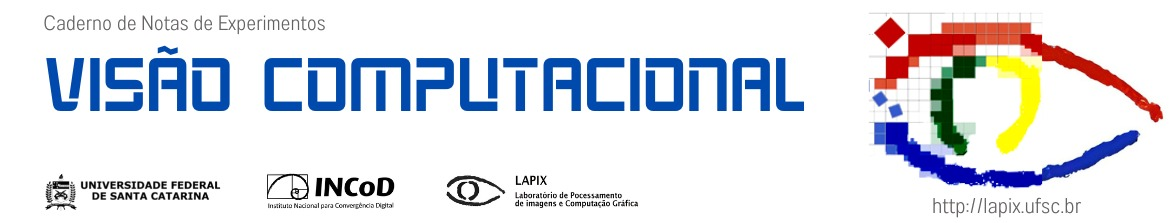






<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/04.2.Convolu%C3%A7%C3%A3o%20para%20Detec%C3%A7%C3%A3o%20de%20Bordas%20e%20Canny.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>


# 04.2. Convolução para Detecção de Bordas e Canny

Neste caderno de notas aqui nós vamos começar mostrando a você como você pode criar um filtro customizado usando a operação de convolução. Em seguida você vai aprender como filtros deste tipo foram utilizados para criar detectores de bordas simples: vamos ver vários detectores de bordas clássicos das décadas de 1960 e 70, como Sobel, Roberts e Robinson e discutir quais são os defeitos de um detector de bordas baseado em uma aplicação simples de uma convolução.

A seguir você vai conhecer um detector de bordas muito mais avançado, o Canny. Este detector é baseado na aplicação de duas convoluções, em sentidos diferentes, seguida de uma limiarização e esqueletonização. Os resultados obtidos com ele são considerados os melhores que você pode conseguir com algoritmos que não apelam para heurísticas complexas, como o método de detecção de curvas salientes de Sha'ashua.


### Initializations

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from scipy import ndimage
import numpy as np
import cv2
from scipy import ndimage
from matplotlib import pyplot as plt
from ipywidgets import interact_manual

# Test if your notebook is running on Google Colab
# You'll use this when choosing between doing interaction via ipywidgets or not. 
try:
  import google.colab
  _ON_COLAB = True
except:
  _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)

Running on Google Colab =  False


### Data Sources

We will be using the ***scikit data module*** to provide us with an image data source. Look here to learn what it is: http://scikit-image.org/docs/dev/api/skimage.data.html It provides the following images:

 - skimage.data.astronaut() - Color image of the astronaut Eileen Collins.

 - skimage.data.camera() - Gray-level “camera” image.

 - skimage.data.checkerboard() - Checkerboard image.

 - skimage.data.chelsea() - Chelsea the cat.

 - skimage.data.clock() - Motion blurred clock.

 - skimage.data.coffee() - Coffee cup.

 - skimage.data.coins() - Greek coins from Pompeii.

 - skimage.data.horse() - Black and white silhouette of a horse.

 - skimage.data.hubble_deep_field() - Hubble eXtreme Deep Field.

 - skimage.data.immunohistochemistry() - Immunohistochemical (IHC) staining with hematoxylin counterstaining.

 - skimage.data.lbp_frontal_face_cascade_filename() - Returns the path to the XML file containing information about the weak classifiers of a cascade classifier trained using LBP features.

 - skimage.data.lfw_subset() - Subset of data from the LFW dataset.

 - skimage.data.logo() - Scikit-image logo, a RGBA image.

 - skimage.data.microaneurysms() - Gray-level “microaneurysms” image.

 - skimage.data.moon() - Surface of the moon.

 - skimage.data.page() - Scanned page.

 - skimage.data.text() - Gray-level “text” image used for corner detection.

 - skimage.data.retina() - Human retina.

 - skimage.data.rocket() - Launch photo of DSCOVR on Falcon 9 by SpaceX.

 - skimage.data.stereo_motorcycle() - Rectified stereo image pair with ground-truth disparities.

In [5]:
import skimage

sources = [
     'skimage.data.astronaut()',
     'skimage.data.camera()',
     'skimage.data.checkerboard()',
     'skimage.data.chelsea()',
     'skimage.data.clock()',
     'skimage.data.coffee()',
     'skimage.data.coins()',
     'skimage.data.horse()',
     'skimage.data.hubble_deep_field()',
     'skimage.data.immunohistochemistry()',
     'skimage.data.lbp_frontal_face_cascade_filename()',
     'skimage.data.lfw_subset()',
     'skimage.data.logo()',
     'skimage.data.microaneurysms()',
     'skimage.data.moon()',
     'skimage.data.page()',
     'skimage.data.text()',
     'skimage.data.retina()',
     'skimage.data.rocket()',
     'skimage.data.stereo_motorcycle()']

### Utility Functions

In [4]:
def to_gray(image):
     # If the image is colored, make a grayscale copy
    if image.shape[-1] == 3:           
        b,g,r = cv2.split(image)       # get b,g,r
        rgb_img = cv2.merge([r,g,b])     # switch it to rgb
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = image
    return gray_img
        

# Simple Convolution

You can detect border using simple, straightforward convolution filters

## Gaussian Blur

Create a Gaussian Kernel

In [6]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

Other examples of Python Gaussian Kernel implementations can be found here:
 * http://subsurfwiki.org/wiki/Gaussian_filter

You can also use ready-made kernels, such as this one from the [astroPy](https://www.astropy.org/) package:

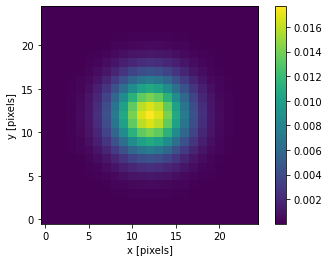

In [7]:
from astropy.convolution import Gaussian2DKernel
gaussian_2D_kernel = Gaussian2DKernel(3)
plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

See also: Box2DKernel, Tophat2DKernel, MexicanHat2DKernel, Ring2DKernel, TrapezoidDisk2DKernel, AiryDisk2DKernel, Moffat2DKernel from https://docs.astropy.org/en/stable/api/astropy.convolution.Kernel2D.html

### Blur it!

In [10]:
def my_gaussian_blur(source, size, sigma):
    global gray_img
    gray_img = to_gray(eval(source))
    global g
    g = gaussian_kernel(size, sigma)
    # Declare blurred as global so you can use it elsewhere...
    global blurred
    # Apply the convolution
    blurred = ndimage.filters.convolve(gray_img, g)
    blurred = blurred.astype(int)
    plt.imshow(blurred, 'gray')

if _ON_COLAB:
    # Google Colab:
    my_gaussian_blur(source='skimage.data.coffee()', size=12, sigma=5.0)
else:
    # Jupyter Notebook:
    interact_manual(my_gaussian_blur, source=sources, size = (3, 21), sigma=(0.2, 10.0))

interactive(children=(Dropdown(description='source', options=('skimage.data.astronaut()', 'skimage.data.camera…

## Sobel

The Sobel Edge Detector employs the following kernels:
![sobel1](sobel.png)
The magnitude and slope of the gradients are calculated as follows:
![sobel12](sobel-arctan.png)

In [8]:
def sobel_filters(image):
    Kx = np.array([[-1, 0, 1], [-4, 0, 4], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 4, 1], [0, 0, 0], [-1, -4, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(image, Kx)
    Iy = ndimage.filters.convolve(image, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

Use Sobel

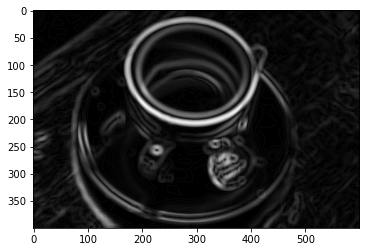

In [11]:
G, theta = sobel_filters(blurred)
#G, theta = sobel_filters(gray_img)
G = G.astype(int)
theta = theta.astype(int)
plt.imshow(G, 'gray')
None

The Sobel Edge Detector is ready-to-run in many librariesd, such as:
 * [OpenCV](https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Gradient_Sobel_Laplacian_Derivatives_Edge_Detection.php)
 * [SciKit-Image](https://scikit-image.org/docs/dev/auto_examples/edges/plot_edge_filter.html)
 
 Scikit-Image has a lot of additional operators, let's test some of them:

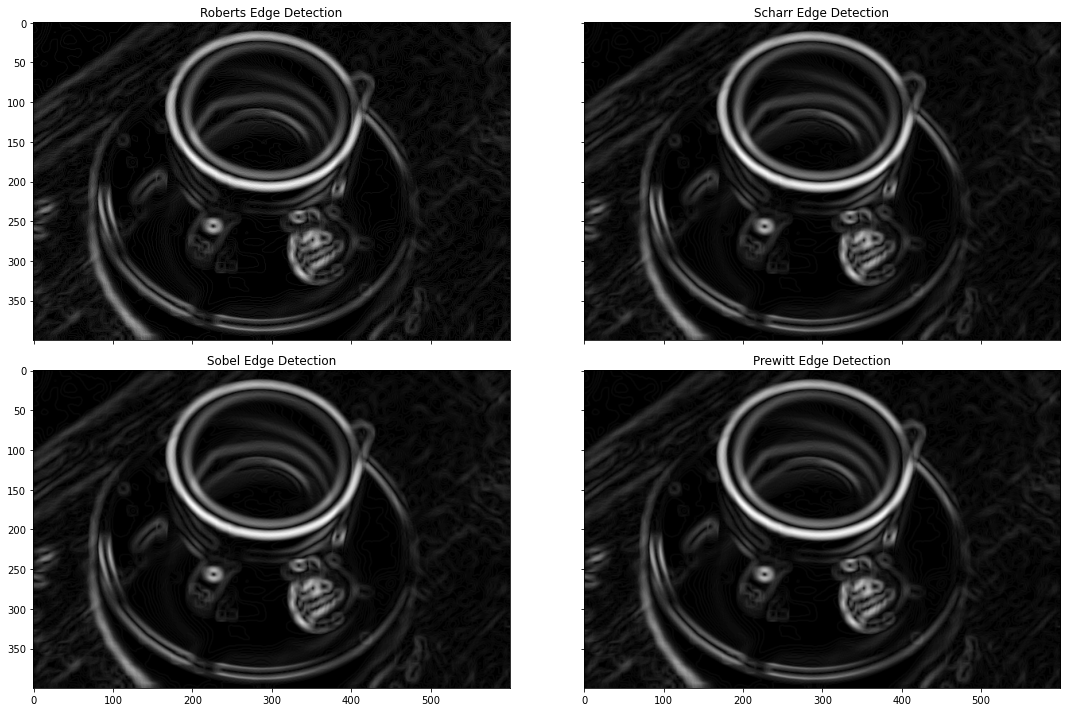

In [12]:
from skimage.data import camera
from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h

# image = to_gray(skimage.data.coffee())
image = blurred
edge_roberts = roberts(image)
edge_sobel = sobel(image)
edge_scharr = scharr(image)
edge_prewitt = prewitt(image)

fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(16, 10))

ax[0,0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0,0].set_title('Roberts Edge Detection')

ax[1,0].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1,0].set_title('Sobel Edge Detection')

ax[0,1].imshow(edge_scharr, cmap=plt.cm.gray)
ax[0,1].set_title('Scharr Edge Detection')

ax[1,1].imshow(edge_prewitt, cmap=plt.cm.gray)
ax[1,1].set_title('Prewitt Edge Detection')

# for a in ax:
#    a.axis('off')

plt.tight_layout()
plt.show()


### Using SciPy

You can also easily achieve edge detection with scipy in python:

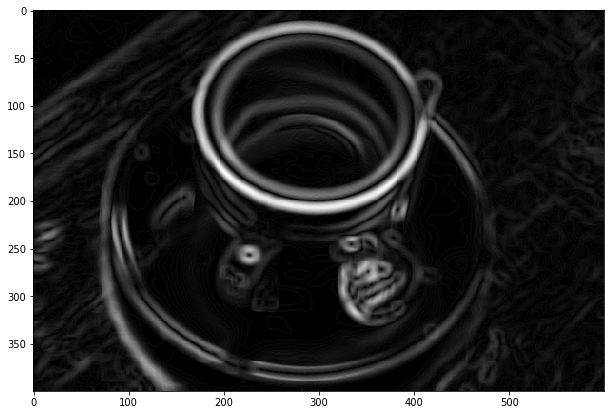

In [103]:
edge_horizont = ndimage.sobel(blurred, 0)
edge_vertical = ndimage.sobel(blurred, 1)
edges = np.hypot(edge_horizont, edge_vertical)
plt.imshow(edges, 'gray')
None

The ndimage package has several spatial filters:
 * https://docs.scipy.org/doc/scipy/reference/ndimage.html

# Canny Edge Detector


The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986. Canny also produced a computational theory of edge detection explaining why the technique works. 

The Process of Canny edge detection algorithm can be broken down to 5 different steps:

    Apply Gaussian filter to smooth the image in order to remove the noise
    Find the intensity gradients of the image
    Apply non-maximum suppression to get rid of spurious response to edge detection
    Apply double threshold to determine potential edges
    Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.
    
 * Source: https://en.wikipedia.org/wiki/Canny_edge_detector
 * Excellent detailed implementation: [TowardsDataScience::Canny Edge Detection Step by Step in Python by Sofiane Sahir](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)

References
----------

1. Canny, J., A Computational Approach To Edge Detection, IEEE Transactions on Pattern Analysis and Machine Intelligence, 8(6):679–698, 1986.

2. R. Deriche, Using Canny's criteria to derive a recursively implemented optimal edge detector, Int. J. Computer Vision, Vol. 1, pp. 167–187, April 1987.




Obs.: We won't use the blurring above because the Canny implementations in OpenCV and SciKit already have it.

## SciKit

The Canny Edge Detector we are using here is this one: http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html Function documentation is here: https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/_canny.py

This implementation of the Canny edge detection algorithm works only on grayscale images!

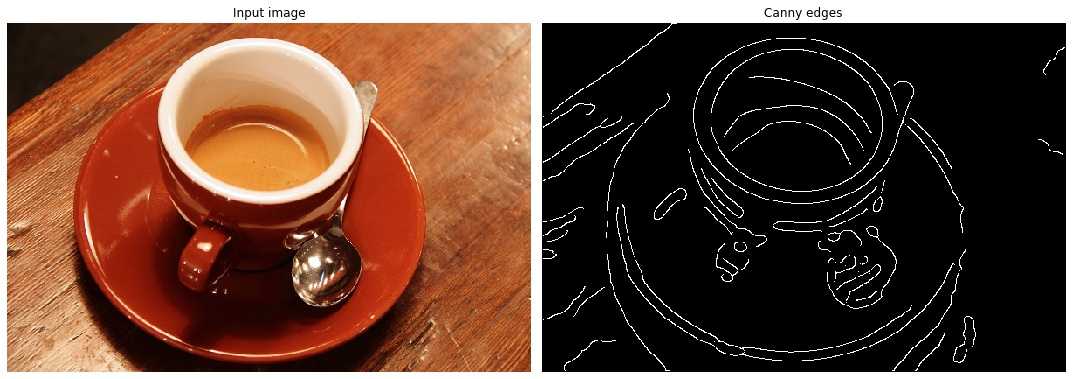

In [67]:
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm


def cannySciKit(source, sigma, low_threshold, high_threshold, use_quantiles):
    # Line finding using the Probabilistic Hough Transform
    image = eval(source)
    gray_img = to_gray(image)

    edges = canny(gray_img, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, use_quantiles=use_quantiles)

    # Generating figure 2
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[0].set_title('Input image')

    ax[1].imshow(edges, cmap=cm.gray)
    ax[1].set_title('Canny edges')

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()
    
if _ON_COLAB:
    # Google Colab:
    cannySciKit(source='skimage.data.coffee()', sigma=4.5, low_threshold=1, high_threshold=25, use_quantiles=False)
else:
    # Jupyter Notebook:
    interact_manual(cannySciKit, source=sources, sigma=(0.2, 11.0), low_threshold=1, high_threshold=25, use_quantiles=False)

## OpenCV

This implementation of the Canny edge detection algorithm works on color images!

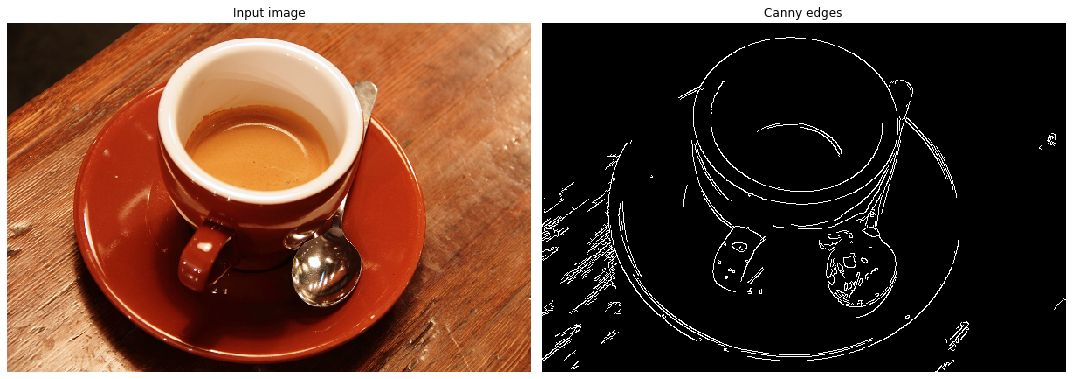

In [65]:
from skimage import data
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

def cannyOpenCV(source,threshold1,threshold2,apertureSize,L2gradient):
    image = eval(source)

    # Create an edge image with the OpenCV canny implementation. Employ color images if you want.
    edges = cv2.Canny(image, threshold1=threshold1, threshold2=threshold2, apertureSize=apertureSize, L2gradient=L2gradient)
    # apertureSize is the aperture size for the Sobel edge detection operator

    # Write the result on the disk
    #cv2.imwrite('cannyEdges3.jpg',edges)
    
    # Create a row of two plots to show the image and the edges
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[0].set_title('Input image')

    ax[1].imshow(edges, cmap=cm.gray)
    ax[1].set_title('Canny edges')

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()


if _ON_COLAB:
    # Google Colab:
    cannyOpenCV(source='skimage.data.coffee()',threshold1=100,threshold2=500,apertureSize=3,L2gradient=True)
else:
    # Jupyter Notebook:
    interact_manual(cannyOpenCV, source=sources, threshold1=100,threshold2=500,apertureSize=3,L2gradient=True)

![rodape lapix ufsc](../rodape-CC.png)